In [1]:
import numpy as np
import pandas as pd
import pandahouse as ph
import seaborn as sns

from CH import Getch
from scipy import stats as ss

In [2]:
# выставляю настройки для отображения графиков
sns.set(font_scale=2, style="whitegrid", rc={'figure.figsize':(20,7)})

In [3]:
# формирую запрос к БД
q = """
SELECT exp_group, 
       user_id,
       countIf(action = 'like') as likes,
       countIf(action = 'view') as views,
       likes/views as ctr
  FROM {db}.feed_actions 
 WHERE toDate(time) between '2024-08-23' and '2024-08-29'
   AND exp_group in (0,1)
 GROUP BY exp_group, user_id
"""

In [4]:
# с помощью класса Getch из модуля CH отправляю запрос и получаю дата-фрейм
df = Getch(q).df
df.tail()

,exp_group,user_id,likes,views,ctr
16814,1,23359,29,188,0.154255
16815,0,3681,13,74,0.175676
16816,1,110956,11,65,0.169231
16817,1,132567,9,27,0.333333
16818,0,11718,1,6,0.166667


<Axes: xlabel='ctr', ylabel='Count'>

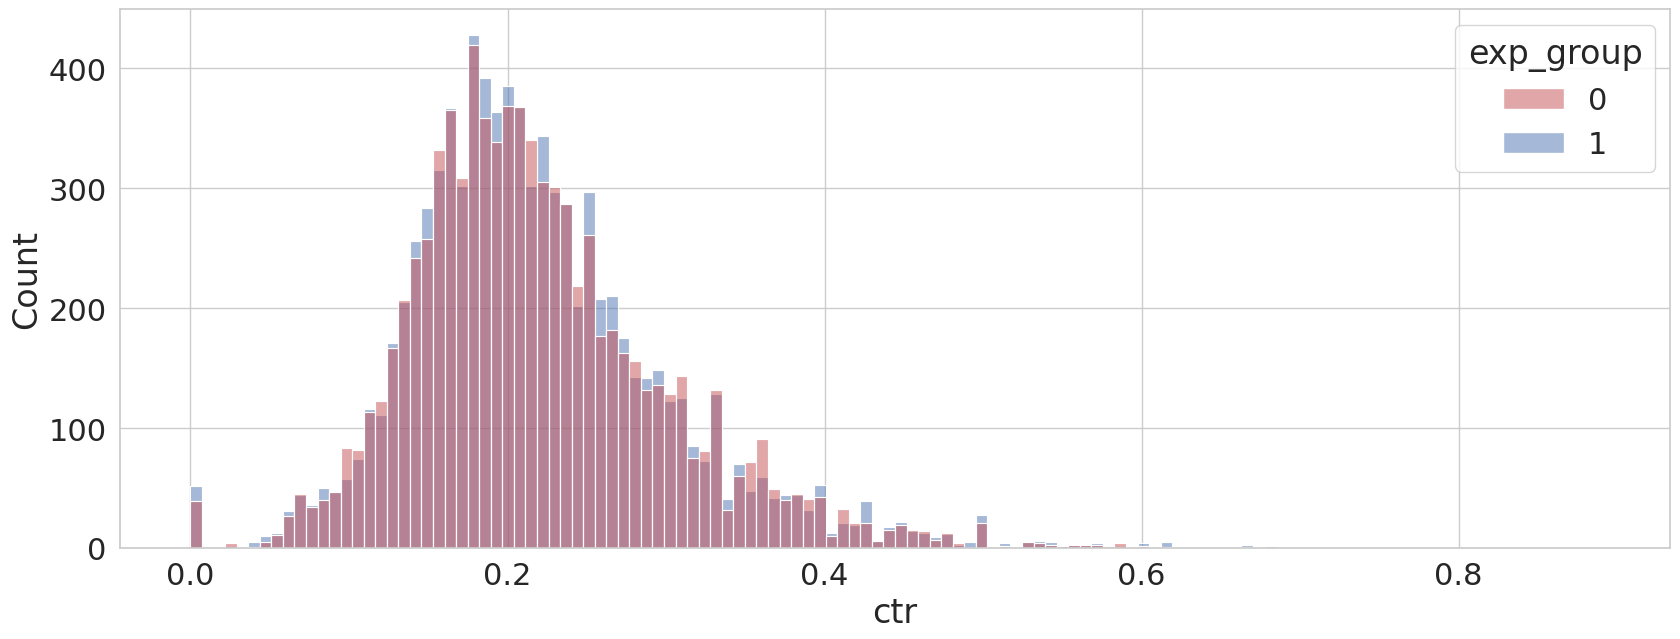

In [5]:
# распределение ctr по группам 0 и 1
sns.histplot(data = df, 
             x='ctr', 
             hue='exp_group', 
             palette = ['r', 'b'],
             kde=False)

Надо удостовериться, что система корректно поделила пользователей на группы, то есть размеры групп примерно одинаковые, а показатели в них сами по себе не различаются до того, как на них была выкачена новая функциональность. Для проверки справедливости этого надо провести А/А-тест.

In [6]:
# размеры групп равнозначны
df.groupby('exp_group').size()

exp_group
0    8328
1    8491
dtype: int64

Если группы действительно не отличаются, то статистически значимые различия между ними встречались бы только в результате случайного ложного срабатывания. Например, если мы отвергаем нулевую гипотезу при условии, что p-value < 0.05, то только приблизительно в 5% случаев у нас бы получались статистические значимые различия между группами 0 и 1.

Для такой проверки буду многократно извлекать подвыборки из наших данных, проводить t-test и в конце проверять, в каком проценте случаев удалось отклонить нулевую гипотезу. 

In [7]:
pvalues = []
for i in range(10000):
    sample_group_1 = df[df.exp_group == 0].ctr.sample(500).tolist()
    sample_group_2 = df[df.exp_group == 1].ctr.sample(500).tolist()
    statistic, pvalue = ss.ttest_ind(sample_group_1, sample_group_2, equal_var=False)
    pvalues.append(pvalue)

<Axes: ylabel='Count'>

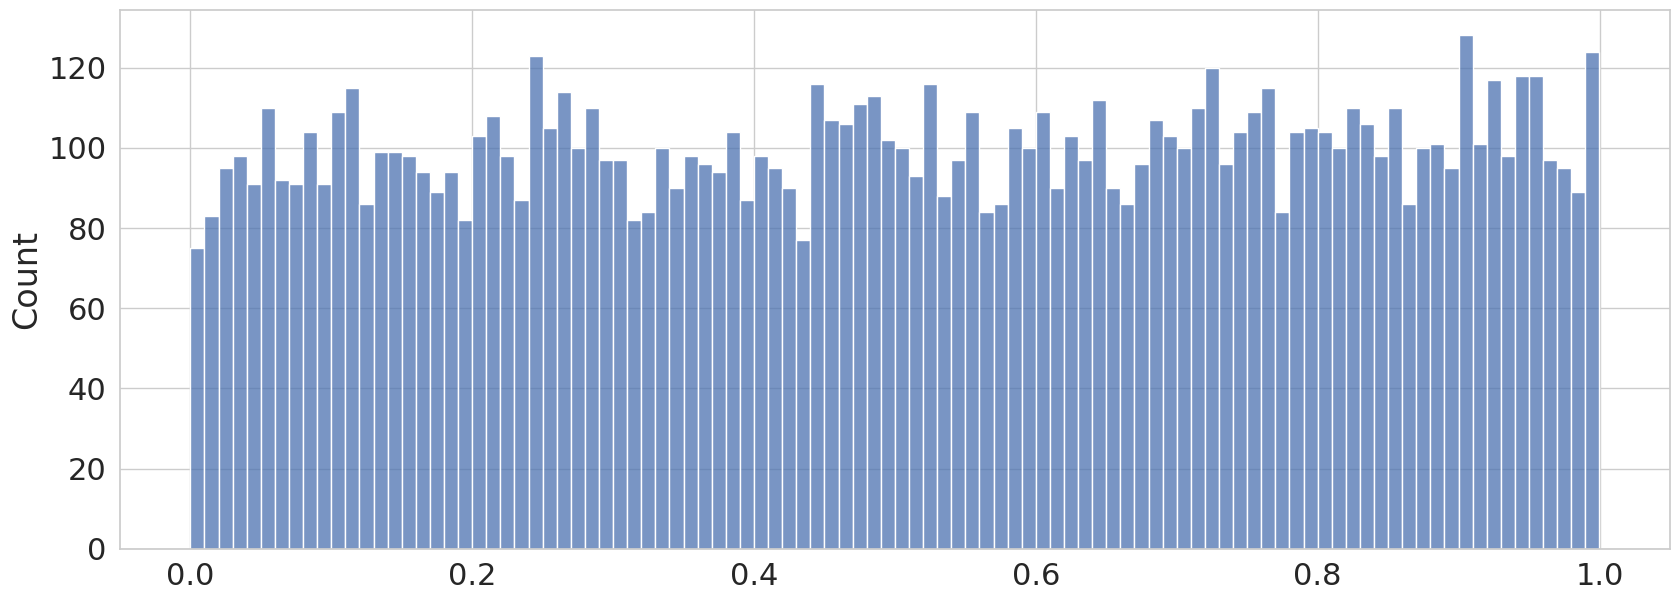

In [8]:
# распределение получившихся значений p-value
sns.histplot(data = pvalues, kde=False, bins=100)

In [9]:
# доля значений, которые ниже порога значимости
len([pvalue for pvalue in pvalues if pvalue <= 0.05]) / len(pvalues)

0.0442

**Значение соответствует ожидаемому, следовательно, пользователи поделены на группы корректно. До выкатывания новой системы рекомендаций группы между собой не различались**